In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable

import glob
import os
import matplotlib.pyplot as plt
import torchvision.models as models
import cv2
import pickle
import random

In [2]:
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_layers)
        self.fc2 = nn.Linear(hidden_layers, hidden_layers)
        self.fc3 = nn.Linear(hidden_layers, output_size)
    
    def forward(self,data):
        x = F.tanh(self.fc1(data))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x,dim = 1)
        

In [3]:
def label2onehot(label_id):
    vector = np.zeros(101)
    vector[label_id] = 1
    return vector

def onehot2label(vector):
    return np.argmax(vector)

In [4]:
def chunk(data,batch_size):
    batches = []
    x = np.arange(len(data) // batch_size + 2)*batch_size
#     print(x)
    for b,e in zip(x[0:-1],x[1:]):
        batches.append(data[b:e])
    return batches    

In [5]:
def encode_batch(minibatch):
    label_batch = []
    feature_batch_vector = []
    for label, feature in minibatch:
        label_batch.append(label)
        feature_batch_vector.append(feature.squeeze())
    return np.array(label_batch), np.array(feature_batch_vector)
    

In [6]:
def validate(test_data,net):
    correct = 0
    for label, feature in test_data:
        x = Variable(torch.FloatTensor(feature)).cuda()
        output = net(x)
        if onehot2label(output.cpu().data.numpy()) == label:
            correct += 1
    return correct / len(test_data)
        
        

In [7]:
def validate_topn(test_data,net,topn_list):
    "topn is a list  [1,2,5]"
    correct = 0
    result = {}
    for topn in topn_list:
        result[topn] = 0 

    for label, feature in test_data:
        x = Variable(torch.FloatTensor(feature)).cuda()
        output = net(x)
        predict_probs = output.cpu().data.numpy()
        
        for topn in topn_list:
            topn_index = np.argsort(predict_probs).squeeze()[-topn:]
#             print(label,topn_index)
            if label in topn_index:
                result[topn] += 1
                
    for topn in topn_list:
        result[topn] /= len(test_data)
    return result.copy()

In [8]:
with open("training_data_vgg19.pkl","rb") as f:
    training_data = pickle.load(f)
    random.shuffle(training_data)
    
with open("test_data_vgg19.pkl","rb") as f:
    test_data = pickle.load(f)

In [9]:
training_batches = chunk(training_data,128)

In [10]:
net = Classifier(4096,2048,101)
learning_rate = 0.0001
optimizer = optim.Adam(net.parameters(), lr=learning_rate )
loss = nn.CrossEntropyLoss()
net.train()
net.cuda()
max_epoch = 100
topn_list = [1,2,3,4,5,6,7,8,9,10]
records = {}
for topn in topn_list:
    records[topn] = {
        "train":[],
        "test":[],
    }
records["loss"] = []



test_loss = []
train_loss = []
for ep in range(max_epoch):
    net.train()
    err_sum = 0 
    for minibatch in training_batches:
        feature_label, feature_vector = encode_batch(minibatch)
        feature_tensor = Variable(torch.FloatTensor(feature_vector)).cuda()
        feature_label = Variable(torch.LongTensor(feature_label)).cuda()
        output = net(feature_tensor)
        error = loss(output, feature_label)
        err_sum += error
        optimizer.zero_grad()
        error.backward()
        optimizer.step()
    
    avg_err = err_sum.cpu().data.numpy()/ len(minibatch)
    records["loss"].append(avg_err)
    net.eval()
    
    print("ep[%d]"%(ep))
    temp_train_result = validate_topn(training_data,net,topn_list)
    temp_test_result = validate_topn(test_data,net,topn_list)
    for topn in topn_list:
        records[topn]["train"].append(temp_train_result[topn])
        records[topn]["test"].append(temp_test_result[topn])
        records
#         print("top%d: %3f"%(topn,records[topn]["train"][-1]))
    print("[top 1]\t training_acc:%f\t test_acc:%f"%(records[1]["train"][-1], records[1]["test"][-1]))
    print("[top 2]\t training_acc:%f\t test_acc:%f"%(records[2]["train"][-1], records[2]["test"][-1]))
    print("[top 5]\t training_acc:%f\t test_acc:%f"%(records[5]["train"][-1], records[5]["test"][-1]))

ep[0]
[top 1]	 training_acc:0.335538	 test_acc:0.339842
[top 2]	 training_acc:0.416307	 test_acc:0.432713
[top 5]	 training_acc:0.519123	 test_acc:0.543485
ep[1]
[top 1]	 training_acc:0.393824	 test_acc:0.383050
[top 2]	 training_acc:0.474989	 test_acc:0.485663
[top 5]	 training_acc:0.577330	 test_acc:0.602693
ep[2]
[top 1]	 training_acc:0.423053	 test_acc:0.396317
[top 2]	 training_acc:0.497485	 test_acc:0.499723
[top 5]	 training_acc:0.594307	 test_acc:0.617545
ep[3]
[top 1]	 training_acc:0.443093	 test_acc:0.403208
[top 2]	 training_acc:0.512311	 test_acc:0.508713
[top 5]	 training_acc:0.604116	 test_acc:0.626574
ep[4]
[top 1]	 training_acc:0.459358	 test_acc:0.409465
[top 2]	 training_acc:0.524734	 test_acc:0.514416
[top 5]	 training_acc:0.611549	 test_acc:0.631406
ep[5]
[top 1]	 training_acc:0.471504	 test_acc:0.412515
[top 2]	 training_acc:0.533539	 test_acc:0.518495
[top 5]	 training_acc:0.616051	 test_acc:0.633901
ep[6]
[top 1]	 training_acc:0.477313	 test_acc:0.408515
[top 2]	

ep[53]
[top 1]	 training_acc:0.702694	 test_acc:0.464040
[top 2]	 training_acc:0.710893	 test_acc:0.581624
[top 5]	 training_acc:0.742326	 test_acc:0.720475
ep[54]
[top 1]	 training_acc:0.702166	 test_acc:0.461149
[top 2]	 training_acc:0.712002	 test_acc:0.580198
[top 5]	 training_acc:0.742802	 test_acc:0.715723
ep[55]
[top 1]	 training_acc:0.705348	 test_acc:0.463762
[top 2]	 training_acc:0.713810	 test_acc:0.582178
[top 5]	 training_acc:0.744161	 test_acc:0.719366
ep[56]
[top 1]	 training_acc:0.706813	 test_acc:0.465030
[top 2]	 training_acc:0.715091	 test_acc:0.584396
[top 5]	 training_acc:0.744703	 test_acc:0.719921
ep[57]
[top 1]	 training_acc:0.708015	 test_acc:0.466218
[top 2]	 training_acc:0.715923	 test_acc:0.583723
[top 5]	 training_acc:0.746063	 test_acc:0.721030
ep[58]
[top 1]	 training_acc:0.708252	 test_acc:0.462535
[top 2]	 training_acc:0.717018	 test_acc:0.580000
[top 5]	 training_acc:0.745838	 test_acc:0.718891
ep[59]
[top 1]	 training_acc:0.710800	 test_acc:0.463921
[

In [11]:
# topn_list = [1,2,5]
# records = {}
# for topn in topn_list:
#     records[topn] = {
#         "train":[],
#         "test":[]
#     }

In [12]:
records[10]

{'test': [0.6257029702970297,
  0.6758811881188119,
  0.6886732673267326,
  0.6961584158415841,
  0.7026930693069307,
  0.7036435643564356,
  0.7028910891089108,
  0.7058613861386138,
  0.7095049504950495,
  0.7103762376237623,
  0.7114455445544554,
  0.7150891089108911,
  0.7205148514851485,
  0.7198019801980198,
  0.720039603960396,
  0.7208316831683168,
  0.7262178217821782,
  0.7276831683168317,
  0.7316831683168317,
  0.7331881188118812,
  0.7365148514851485,
  0.7491485148514851,
  0.7558811881188119,
  0.76,
  0.772950495049505,
  0.7756831683168317,
  0.7748118811881188,
  0.7773069306930693,
  0.7775841584158416,
  0.777940594059406,
  0.7814257425742575,
  0.7797227722772277,
  0.783009900990099,
  0.783009900990099,
  0.7841980198019802,
  0.7862970297029703,
  0.7876039603960396,
  0.7887920792079208,
  0.7888712871287129,
  0.7904158415841585,
  0.7885940594059406,
  0.7890693069306931,
  0.7962376237623763,
  0.796950495049505,
  0.7958415841584159,
  0.7981386138613862,


In [13]:
import matplotlib.pyplot as plt
import numpy as np

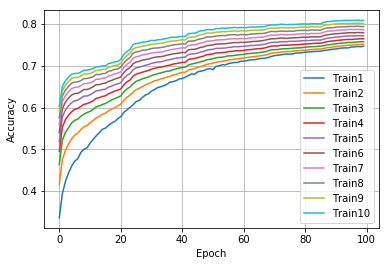

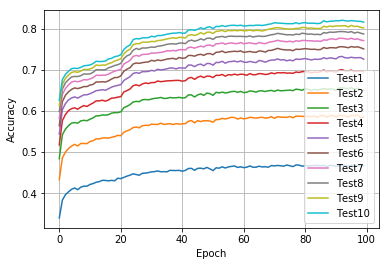

In [14]:
legends = []
for topn in topn_list:
    plt.plot(records[topn]["train"])
    legends.append("Top%d"%topn)
    
#     plt.plot(records[topn]["test"])
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(legends)
plt.title("Training Set")
plt.show()

legends = []
for topn in topn_list:
    plt.plot(records[topn]["test"])
    legends.append("Top%d"%topn)
    
#     plt.plot(records[topn]["test"])
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Set")
plt.legend(legends)
plt.show()

In [15]:
import pickle
with open("vgg19_data.pkl","wb") as f:
    temp = {
        "net":net,
        "records":records
    }
    pickle.dump(temp,f)